In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
data = xr.open_dataset('fwdP3.nc')

[None, None, None]

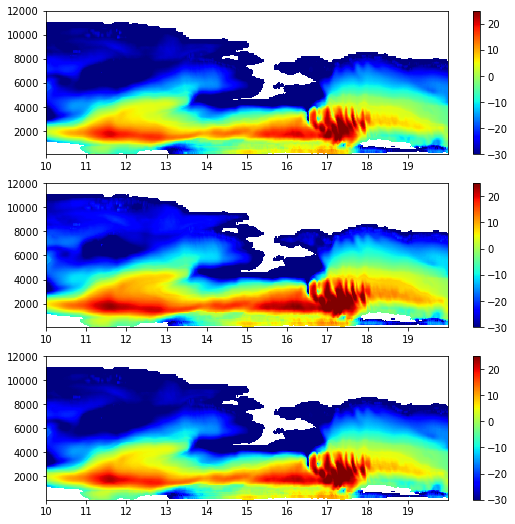

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
mesh = axs[0].pcolormesh(data.time, data.height, data.Zssrga.loc[dict(frequency='X')].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(data.time, data.height, data.Ztm.loc[dict(frequency='X')].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[1])
mesh = axs[2].pcolormesh(data.time, data.height, data.Zliu09.loc[dict(frequency='X')].T, vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[2])
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
#fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')